# Tite-seq modeling

Ideas for modeling Tite-seq data, building on Tyler's work at https://github.com/jbloomlab/Ab-CGGnaive_DMS/blob/main/results/summary/compute_binding_Kd.md

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpy as np
import scipy
import jax.numpy as jnp
import jax
from scipy.special import expit, logit
from jax.scipy.special import expit as jexpit, logit as jlogit
from scipy.optimize import least_squares
import jaxopt
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fcsparser
import urllib

In [2]:
outdir = "output/tite-seq-modeling"

## Data

Load tite-seq data

In [3]:
barcode_runs = pd.read_csv("~/Downloads/barcode_runs.csv")
barcode_runs.query("sample.str.startswith('TiteSeq')", inplace=True)
barcode_runs.set_index(["library", "sample"], inplace=True)
variant_counts = pd.read_csv("~/Downloads/variant_counts.csv")
variant_counts.query("sample.str.startswith('TiteSeq')", inplace=True)
codon_variant_table = pd.read_csv("~/Downloads/codon_variant_table.csv")
# codon_variant_table.query("n_aa_substitutions == 1", inplace=True)

Define concentrations and bins

In [4]:
concs = np.array([1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 0])
bins = np.array([1, 2, 3, 4])
b = np.array([-288., 136., 2000., 29421., 262143.])
# b[0] = 0.0
bins, b

(array([1, 2, 3, 4]),
 array([-2.88000e+02,  1.36000e+02,  2.00000e+03,  2.94210e+04,
         2.62143e+05]))

Combine tables to make a single barcode level frame

In [5]:
df_barcodes = variant_counts.merge(codon_variant_table, on=("barcode", "library"), how="inner")
df_barcodes["antigen_concentration"] = concs[df_barcodes["sample"].str.extract(r"TiteSeq_(\d+)").astype(int) - 1]
df_barcodes["bin"] = df_barcodes["sample"].str[-1].astype(int)
df_barcodes.drop(columns=["codon_substitutions", "n_codon_substitutions", "target", "variant_call_support"], inplace=True)
df_barcodes.rename(columns={"aa_substitutions": "variant",
                            "count": "read_count"},
                   inplace=True)
df_barcodes = df_barcodes.loc[:, ["sample", "library", "variant", "n_aa_substitutions", "barcode", "antigen_concentration", "bin", "read_count"]]
df_barcodes.sort_values(by=list(df_barcodes.columns), inplace=True)
df_barcodes.variant = df_barcodes.variant.fillna("WT")

df_barcodes

,sample,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin,read_count
88956,TiteSeq_01_bin1,lib1,A104C,1,AAAAACATCAGTTGGT,0.000001,1,0
103644,TiteSeq_01_bin1,lib1,A104C,1,AAAACACTATCTAGGA,0.000001,1,0
134352,TiteSeq_01_bin1,lib1,A104C,1,AAAATTCAAAATTATC,0.000001,1,0
235440,TiteSeq_01_bin1,lib1,A104C,1,AACAAAAGTGTATGTT,0.000001,1,0
397908,TiteSeq_01_bin1,lib1,A104C,1,AAGTTATGAATACCCT,0.000001,1,0
...,...,...,...,...,...,...,...,...
6925787,TiteSeq_09_bin4,lib2,WT,0,TTTTTCATGTATATGC,0.000000,4,0
6927047,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAAAGTTCATA,0.000000,4,0
6927155,TiteSeq_09_bin4,lib2,WT,0,TTTTTTACCTTTACCT,0.000000,4,0
6927227,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAGAAGCGAAG,0.000000,4,0


In [6]:
barcode_runs.concentration = concs[barcode_runs.concentration.astype(int) - 1]
barcode_runs

sample_type  sort_bin  concentration    date  \
library sample                                                         
lib1    TiteSeq_01_bin1     TiteSeq         1   1.000000e-06  210624   
        TiteSeq_01_bin2     TiteSeq         2   1.000000e-06  210624   
        TiteSeq_01_bin3     TiteSeq         3   1.000000e-06  210624   
        TiteSeq_01_bin4     TiteSeq         4   1.000000e-06  210624   
        TiteSeq_02_bin1     TiteSeq         1   1.000000e-07  210624   
...                             ...       ...            ...     ...   
lib2    TiteSeq_08_bin4     TiteSeq         4   1.000000e-13  210624   
        TiteSeq_09_bin1     TiteSeq         1   0.000000e+00  210624   
        TiteSeq_09_bin2     TiteSeq         2   0.000000e+00  210624   
        TiteSeq_09_bin3     TiteSeq         3   0.000000e+00  210624   
        TiteSeq_09_bin4     TiteSeq         4   0.000000e+00  210624   

                         number_cells  \
library sample                          
lib1    TiteSeq_01_bin1          9967   
        TiteSeq_01_bin2        100694   
        TiteSeq_01_bin3        910229   
        TiteSeq_01_bin4       4152079   
        TiteSeq_02_bin1         78772   
...                               ...   
lib2    TiteSeq_08_bin4            23   
        TiteSeq_09_bin1       5016672   
        TiteSeq_09_bin2         86684   
        TiteSeq_09_bin3            50   
        TiteSeq_09_bin4             3   

                                                                        R1  
library sample                                                              
lib1    TiteSeq_01_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin2  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin3  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_02_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
...                                                                    ...  
lib2    TiteSeq_08_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin2  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin3  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  

[72 rows x 6 columns]

Use total cell counts and total read counts in each concentration and bin to estimate the number of cells with each barcode

In [7]:
def normalize_read_count(df):
    library = df.library.iloc[0]
    sample = df["sample"].iloc[0]
    total_reads = df.read_count.sum()
    total_cells = barcode_runs.number_cells[(library, sample)]
    df["estimated_cell_count"] = total_cells * df.read_count / total_reads
    return df

df_barcodes = df_barcodes.groupby(["library", "sample"]).apply(normalize_read_count).reset_index(drop=True)
df_barcodes

,sample,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin,read_count,estimated_cell_count
0,TiteSeq_01_bin1,lib1,A104C,1,AAAAACATCAGTTGGT,0.000001,1,0,0.0
1,TiteSeq_01_bin1,lib1,A104C,1,AAAACACTATCTAGGA,0.000001,1,0,0.0
2,TiteSeq_01_bin1,lib1,A104C,1,AAAATTCAAAATTATC,0.000001,1,0,0.0
3,TiteSeq_01_bin1,lib1,A104C,1,AACAAAAGTGTATGTT,0.000001,1,0,0.0
4,TiteSeq_01_bin1,lib1,A104C,1,AAGTTATGAATACCCT,0.000001,1,0,0.0
...,...,...,...,...,...,...,...,...,...
6927439,TiteSeq_09_bin4,lib2,WT,0,TTTTTCATGTATATGC,0.000000,4,0,0.0
6927440,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAAAGTTCATA,0.000000,4,0,0.0
6927441,TiteSeq_09_bin4,lib2,WT,0,TTTTTTACCTTTACCT,0.000000,4,0,0.0
6927442,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAGAAGCGAAG,0.000000,4,0,0.0


## Barcode aggregation

The current $K_D$ estimation procedure does a separate fit for each barcode, then computes the median of the estimated $\log K_D$ across barcodes for each variant.
Should we instead aggregate read counts from all barcodes for a given variant, and estimate a single $K_D$?

In [8]:
df_variants = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "antigen_concentration", "bin"]).agg({"read_count": "sum",
                                                                                                                     "estimated_cell_count": "sum",
                                                                                                                     "barcode": "count"}).reset_index()
df_variants.sort_values(by=list(df_variants.columns), inplace=True)
df_variants

,library,variant,n_aa_substitutions,antigen_concentration,bin,read_count,estimated_cell_count,barcode
0,lib1,A104C,1,0.000000e+00,1,2663,1245.976128,25
1,lib1,A104C,1,0.000000e+00,2,25,24.182027,25
2,lib1,A104C,1,0.000000e+00,3,0,0.000000,25
3,lib1,A104C,1,0.000000e+00,4,0,0.000000,25
4,lib1,A104C,1,1.000000e-13,1,578,1488.709081,25
...,...,...,...,...,...,...,...,...
821551,lib2,Y94W R145M,2,1.000000e-07,4,26,15.382275,1
821552,lib2,Y94W R145M,2,1.000000e-06,1,0,0.000000,1
821553,lib2,Y94W R145M,2,1.000000e-06,2,0,0.000000,1
821554,lib2,Y94W R145M,2,1.000000e-06,3,0,0.000000,1


We filter missing concentrations for each barcode in the barcode data, and for each variant in the variant data. Missing means the sum of reads is zero.

In [9]:
def conc_filter_fn(df):
    return all(df.groupby("antigen_concentration").read_count.sum() > 0)

In [10]:
df_barcodes = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "barcode"]).filter(conc_filter_fn)
df_variants = df_variants.groupby(["library", "variant", "n_aa_substitutions"]).filter(conc_filter_fn)

## Model elaborations

Model the latent fluorescence $z$ at each concentration $x$ via a log-normal distribution:
$$
\log z\mid x \sim \mathcal{N}\left(\log f(x), \ σ^2\right),
$$
with mean given by a scaled Hill function
$$
f(x) = \alpha\left(\frac{x}{x + K_d}\right) + \beta,
$$
where $\beta$ models cell autofluorescence, $\alpha$ is the maximum fluorescence increase (a function of variant surface expression), and $\sigma^2$ is the variance.
The probability that a variant appears within a fluorescence bin defined by the interval $[b_i, b_{i-1})$ is obtained by integrating the Gaussian over the bin interval:
$$
p_i = \Phi\left(\frac{\log b_i - \log f(x)}{\sigma}\right) - \Phi\left(\frac{\log b_{i-1} - \log f(x)}{\sigma}\right),
$$
where $\Phi$ is the CDF of the standard normal distribution.
We observe read count $y_i$ from the cells in each bin, which we model as a gamma mixture of Poissons (negative binomial):
$$
y_i \mid \lambda p_i \sim \mathrm{NB}\left(\frac{1}{\phi}, \frac{1}{1+\phi \lambda p_i}\right),
$$
where $\lambda$ is the mean read count per cell and $\phi$ is the overdispersion parameter.

**Note:** many of the parameters are shared by all variants.
Only $\alpha$, $\lambda$, and $K_d$ are variant-specific.

## FACS data

In [11]:
fcs_df = pd.DataFrame()

pe_grid = np.logspace(np.log10(b[1]) - 2, np.log10(b[-1]), 25)
logf_grid = np.log(pe_grid)

logf_pdfs1 = np.full((len(concs), len(logf_grid)), np.nan)
logf_pdfs2 = np.full((len(concs), len(logf_grid)), np.nan)

ct = 5
for library in (1, 2):
    for concentration_idx in range(len(concs)):
        ct += 1
        url = f"https://github.com/jbloomlab/Ab-CGGnaive_DMS/raw/main/exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_{(library - 1) * len(concs) + concentration_idx + 1:03d}_P4_{ct:03d}.fcs"
        title_str = url.split("/")[-1].split(".")[0]
        file = f"{outdir}/{title_str}.fcs"
        urllib.request.urlretrieve(url, file)
        meta, fcs = fcsparser.parse(file, reformat_meta=True)
        spill_values = meta["SPILL"].split(',')
        n_ch = int(spill_values[0])
        spill_df = pd.DataFrame(np.array(spill_values[(n_ch + 1):], dtype=np.float64).reshape((n_ch, n_ch)).T,
                                index=spill_values[1:(n_ch + 1)])
        fcs[spill_df.index] = np.linalg.solve(spill_df, fcs[spill_df.index].T).T
        fcs["sample"] = title_str
        library = (int(title_str.split("_")[3]) - 1) // len(concs) + 1
        concentration_idx = int(title_str.split("_")[3]) % len(concs) - 1
        concentration = concs[concentration_idx]
        fcs["library"] = library
        fcs["concentration"] = concentration
        fcs_df = pd.concat(
            (fcs_df,
             fcs[["library",
                  "sample",
                  "concentration",
                  "PE-A",
                  ]
                 ]
             ),
             ignore_index=True)
        
        # fcs["PE-A"] = np.clip(fcs["PE-A"], b[0], b[-1])

        not_truncated_idxs = np.where((fcs["PE-A"] > 0) & (fcs["PE-A"] < b[-1]))[0]
        kde = scipy.stats.gaussian_kde(
            np.log(fcs["PE-A"].values[not_truncated_idxs]),
            bw_method=.1)
        truncated_fraction = (fcs["PE-A"] >= b[-1]).sum() / len(fcs)
        if library == 1:
            logf_pdfs1[concentration_idx, :] = kde(logf_grid) #/ jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)
        else:
            logf_pdfs2[concentration_idx, :] = kde(logf_grid) #/ jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)

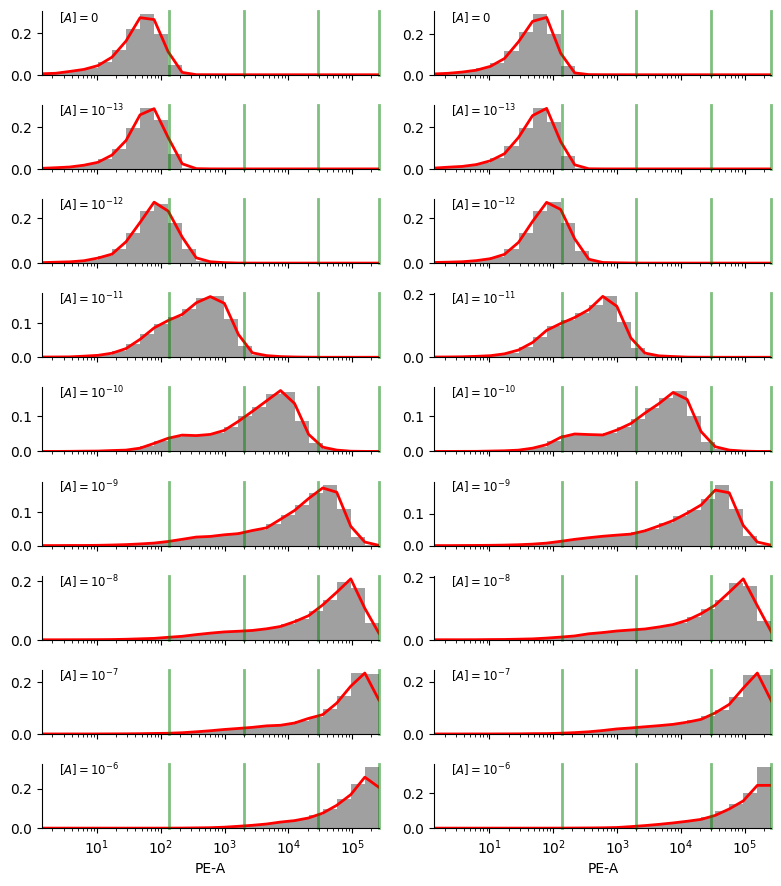

In [12]:
g = sns.displot(
    data=fcs_df.loc[(fcs_df["PE-A"] >= np.exp(logf_grid)[0]) & (fcs_df["PE-A"] <= np.exp(logf_grid)[-1])],
    x="PE-A",
    row="concentration",
    col="library",
    bins=np.exp(logf_grid),
    # bins=np.concatenate((np.linspace(fcs_df["PE-A"].min(), 0, 10), np.logspace(1, 6, 100))),
    # bins=fcs_df["PE-A"].min() + np.logspace(1, 6, 100),
    # stat="frequency",
    stat="probability",
    common_norm=False,
    color="gray",
    height=1, aspect=4,
    facet_kws=dict(sharey=False),
    )

g.set_ylabels("")
g.set_titles("")

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i, j].plot(np.exp(logf_grid),
                          (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :] / (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :].sum(),
                          color="r", lw=2)
        for bi in b[1:]:
            g.axes[i, j].axvline(bi, color="g", clip_on=False, alpha=0.5, lw=2)
            if g.row_names[i] > 0:
                power = int(np.log10(g.row_names[i]))
                title = f"$[A] = 10^{{{power}}}$"
            else:
                title = "$[A] = 0$"
            g.axes[i, j].set_title(title,
                        fontsize='small',
                        loc='left',
                        x=0.05,
                        y=0.7,
                        )

plt.xscale("log")
plt.xlim(np.exp(logf_grid[0]), np.exp(logf_grid[-1]))

plt.tight_layout()
plt.show()

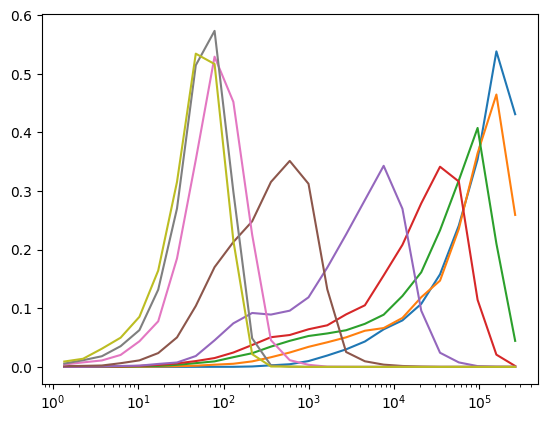

In [13]:
plt.plot(np.exp(logf_grid), logf_pdfs1.T)
plt.xscale("log")

In [14]:
fcs_df["PE-A"] < b[0]

0         False
1         False
2         False
3         False
4         False
          ...  
351067    False
351068    False
351069    False
351070    False
351071    False
Name: PE-A, Length: 351072, dtype: bool

In [15]:
meta, data = fcsparser.parse(file, reformat_meta=True)

spill_values = meta["SPILL"].split(',')
n = int(spill_values[0])  # The first item is the number of channels
spill_df = pd.DataFrame(np.array(spill_values[3:], dtype=np.float64).reshape((n, n)).T,
                        index=spill_values[1:3],
                        columns=spill_values[1:3])
spill_df


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


In [16]:
with pd.option_context("display.precision", 10):
    print("spillover matrix")
    display(spill_df)
    print("inverse spillover matrix")
    display(pd.DataFrame(np.linalg.inv(spill_df), index=spill_df.columns, columns=spill_df.columns))

spillover matrix


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


inverse spillover matrix


,PE-A,FITC-A
PE-A,1.0000255007,-0.0030000765
FITC-A,-0.0085002168,1.0000255007


Spillover matrix mixes two true signals into two observed signals:
$$
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
$$
So to recover the true signals from the observed signals, we invert the matrix:
$$
\begin{align*}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
&=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}^{-1}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}\\
&=
\begin{pmatrix}
1.0000255007 & -0.0030000765 \\
-0.0085002168 & 1.0000255007 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
\end{align*}\\
$$

/Users/wsdewitt/miniconda3/envs/jax-metal/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


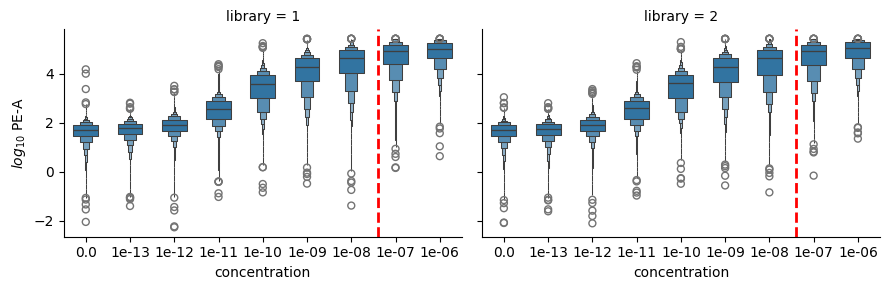

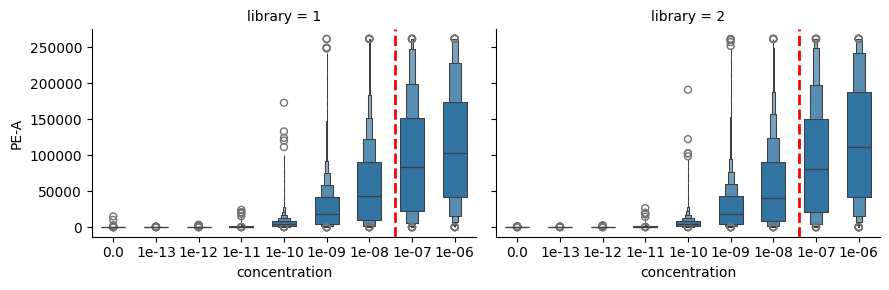

In [17]:
fcs_df["$log_{10}$ PE-A"] = np.log10(fcs_df["PE-A"])
for yval in ("$log_{10}$ PE-A", "PE-A"):
    g = sns.catplot(data=fcs_df,
                    kind="boxen",
                    col="library",
                    x="concentration",
                    y=yval,
                    gap=.3,
                    height=3, aspect=1.5,
                )
    g.refline(x=6 + np.log10(4), color="r", linestyle='--', lw=2, label="BLI naive $K_D$")
    # plt.yscale("symlog", linthresh=100, linscale=0.2)
    # plt.ylim(b[0], 1.1 * b[-1])
    plt.tight_layout()
    plt.show()

In [18]:
logf_pdfs1 = np.flip(logf_pdfs1, axis=0)
logf_pdfs2 = np.flip(logf_pdfs2, axis=0)

Modeling functions

In [19]:
jax.devices()
# jax.device_put(x, device=None)

[CpuDevice(id=0)]

In [20]:
def f(logx, logα, logβ, logKd):
    n = 1.0  # Hill coefficient
    return jnp.exp(logα) * jexpit(n * (logx - logKd)) + jnp.exp(logβ)

# NOTE: this function assumes truncation on the high bin, so all counts above it are in that bin (infinite upper boundary)
def logp(logx, logα, logβ, logKd, b, logσ):
    b = jnp.array(b)
    fs = f(logx, logα, logβ, logKd)
    σ = jnp.exp(logσ)
    logcdf_points = jax.scipy.stats.norm.logcdf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    logsf_points = jax.scipy.stats.norm.logsf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    first = logcdf_points[:, 0, None]
    middle = jax.scipy.special.logsumexp(jnp.concatenate((logcdf_points[:, 1:, None], logcdf_points[:, 0:-1, None]),
                                                       axis=-1),
                                       b=jnp.array([1, -1]),
                                       axis=-1)
    # this accounts for the fact that the last bin includes all values above the last boundary
    last = logsf_points[:, -1, None]
    return jnp.concatenate((first, middle, last), axis=-1)     

def p(logx, logα, logβ, logKd, b, logσ):
    return jnp.exp(logp(logx, logα, logβ, logKd, b, logσ))

@jax.jit
def one_neg_log_likelihood(logγ, logα, logKd, y, logβ, logσ, logx, b, cells, reads_per_cell):
    # We have a compound poisson distribution for the read count in each (concentration, bin)
    # We match moments to the negative binomial distribution
    logp_ = logp(logx, logα, logβ, logKd, b, logσ)
    # expected cell count matrix
    λ_cell = cells[:, None] * jnp.exp(logγ + logp_[None, :])
    nbinom_logp = - jnp.log1p(reads_per_cell)
    
    ll = jax.scipy.special.gammaln(λ_cell + y) - jax.scipy.special.gammaln(λ_cell) + λ_cell * nbinom_logp

    return -ll.sum()

vmap_one_neg_log_likelihood = jax.vmap(one_neg_log_likelihood, in_axes=(0, 0, 0, 0, None, None, None, None, None, None))

@jax.jit
def DKL(params, data):
    logγs, logαs, logKds, logσ = params
    Y, wt_idx, logx, b, cells, reads_per_cell, logβ, logf_grid, logf_pdfs, single_mut_idxs, other_mut_idxs = data
    σ = jnp.exp(logσ)
    fs = f(logx[:, None], logαs[None, :], logβ, logKds[None, :])
    logf_pdfs_predicted = jax.scipy.stats.norm.pdf(logf_grid[None, :, None], loc=jnp.log(fs[:, None, :]), scale=σ).mean(-1)
    return jax.scipy.integrate.trapezoid(jax.scipy.special.kl_div(logf_pdfs, logf_pdfs_predicted), x=logf_grid, axis=1).sum()

@jax.jit
def neg_log_likelihood(params, data,
                       μ=0.0,  # prior matching weight
                       λ=0.0,  # Lagrange multiplier estimate for Augmented Lagrangian iterates
                       γ_ridge=0.0, α_ridge=0.0, Kd_ridge=0.0,
                       ):
    logγs, logαs, logKds, logσ = params
    Y, wt_idx, logx, b, cells, reads_per_cell, logβ, logf_grid, logf_pdfs, single_mut_idxs, other_mut_idxs = data
    logγs = logγs * jnp.ones(Y.shape[0])
    logαs = logαs * jnp.ones(Y.shape[0])
    logKds = logKds * jnp.ones(Y.shape[0])
    
    nll = vmap_one_neg_log_likelihood(logγs, logαs, logKds, Y, logβ, logσ, logx, b, cells, reads_per_cell).mean()

    D = DKL(params, data)
    prior_penalty = (μ / 2) * D ** 2 + λ * D

    logγ_penalty = γ_ridge * (((logγs[single_mut_idxs] - logγs[single_mut_idxs].mean()) ** 2).sum() - ((logγs[other_mut_idxs] - logγs[other_mut_idxs].mean()) ** 2).sum())
    # logα_nonwt_mean = (logαs.sum() - logαs[wt_idx]) / (len(logαs) - 1)
    # logα_penalty = α_ridge * (((logαs - logα_nonwt_mean) ** 2).sum() - ((logαs[wt_idx] - logα_nonwt_mean) ** 2).sum())
    # logKd_nonwt_mean = (logKds.sum() - logKds[wt_idx]) / (len(logKds) - 1)
    # logKd_penalty = Kd_ridge * (((logKds - logKd_nonwt_mean) ** 2).sum() - ((logKds[wt_idx] - logKd_nonwt_mean) ** 2).sum())
    logα_penalty = α_ridge * ((logαs - logαs[wt_idx]) ** 2).sum()
    logKd_penalty = Kd_ridge * ((logKds - logKds[wt_idx]) ** 2).sum()

    return nll + logγ_penalty + logα_penalty + logKd_penalty + prior_penalty


@jax.jit
def one_mean_bin_loss(logα, logKd, ynorm, logβ, logσ, logx, b, binfs,
                      ):
    mean_bin_dat = (ynorm * binfs).sum(1) / ynorm.sum(1)
    ps = p(logx, logα, logβ, logKd, b, logσ)
    mean_bin_model = (ps * binfs).sum(1) / ps.sum(1)
    w = jnp.log(ynorm.sum(-1, keepdims=True))
    # w = jnp.ones(Ynorm.shape[1])
    curve_fit_loss = (w * (mean_bin_model - mean_bin_dat) ** 2).sum()
    return curve_fit_loss

vmap_mean_bin_loss = jax.vmap(one_mean_bin_loss, in_axes=(0, 0, 0, None, None, None, None, None,
                                                          ))

@jax.jit
def mean_bin_loss(params, data,
                  prior_weight=0.0,
                #   L2_logα=0.0, L2_logKd=0.0,
                  ):
    logαs, logKds, logσ = params
    Ynorm, logx, b, binfs, logβ, logf_grid, logf_pdfs = data
    # Ynorm, logx, b, binfs, ref_idx = data
    logαs = logαs * jnp.ones(Ynorm.shape[0])
    logKds = logKds * jnp.ones(Ynorm.shape[0])

    curve_fit_loss = vmap_mean_bin_loss(logαs, logKds, Ynorm, logβ, logσ, logx, b, binfs,
                                        ).mean()
    # return curve_fit_loss
    # return (curve_fit_loss
    #         + L2_logα * ((logαs - logαs[ref_idx]) ** 2).mean()
    #         + L2_logKd * ((logKds - logKds[ref_idx]) ** 2).mean()
    #         )
    σ = jnp.exp(logσ)
    fs = f(logx[:, None], logαs[None, :], logβ, logKds[None, :])
    logf_pdfs_predicted = jax.scipy.stats.norm.pdf(logf_grid[None, :, None], loc=jnp.log(fs[:, None, :]), scale=σ).mean(-1)
    logf_pdfs_predicted = logf_pdfs_predicted / jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1)[:, None]
    # plt.plot(logf_grid, logf_pdfs.T, c="C0")
    # plt.plot(logf_grid, logf_pdfs_predicted.T, c="C1")
    # plt.show()
    # print(jax.scipy.integrate.trapezoid(logf_pdfs, x=logf_grid, axis=1))
    # print(jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1))
    prior_loss = jax.scipy.integrate.trapezoid((logf_pdfs_predicted - logf_pdfs) ** 2, x=logf_grid, axis=1).sum()

    return curve_fit_loss + prior_weight * prior_loss


Read and cell count data

In [21]:
R_df = df_variants.rename(columns={"antigen_concentration": "concentration",
                                   "read_count": "number_reads"}).groupby(["library", "concentration", "bin"]).number_reads.sum().sort_index()
C_df = barcode_runs.reset_index().rename(columns={"sort_bin": "bin"}).set_index(["library", "concentration", "bin"]).number_cells.sort_index()
assert C_df.index.equals(R_df.index)

counts_df = pd.concat((R_df, C_df), axis=1, verify_integrity=True)

counts_df

number_reads  number_cells
library concentration bin                            
lib1    0.000000e+00  1        10641738       4994518
                      2          100855         97766
                      3             244           156
                      4              38            57
        1.000000e-13  1         1891730       4879499
...                                 ...           ...
lib2    1.000000e-07  4         6067003       3595640
        1.000000e-06  1            1599          5023
                      2          138321         85666
                      3         1720726        910355
                      4         5059461       4087566

[72 rows x 2 columns]

Jax data from pandas frames

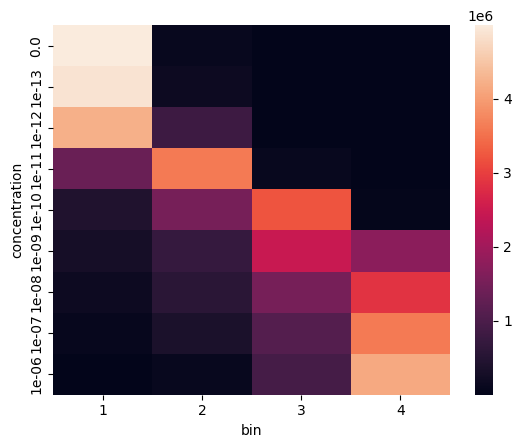

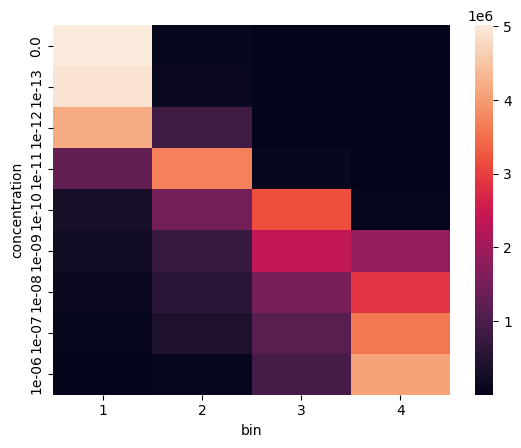

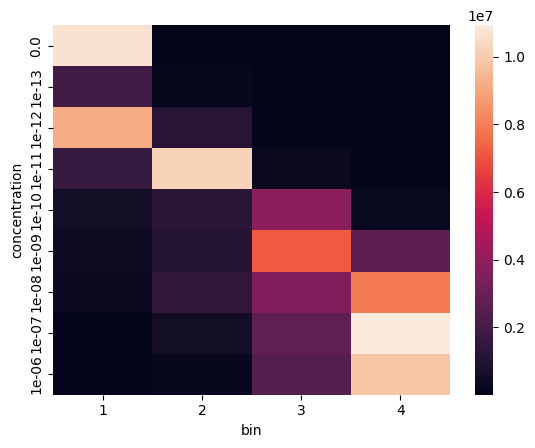

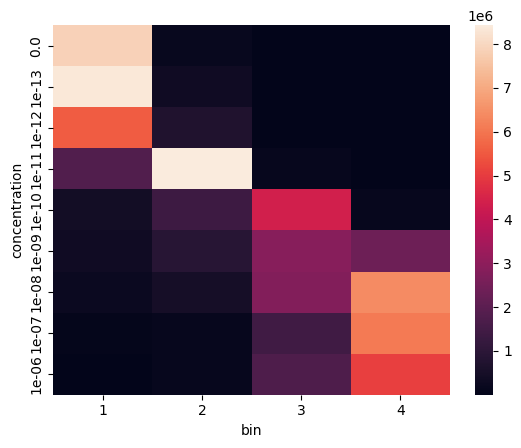

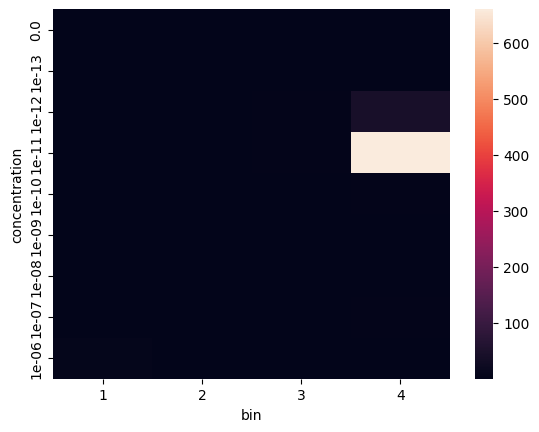

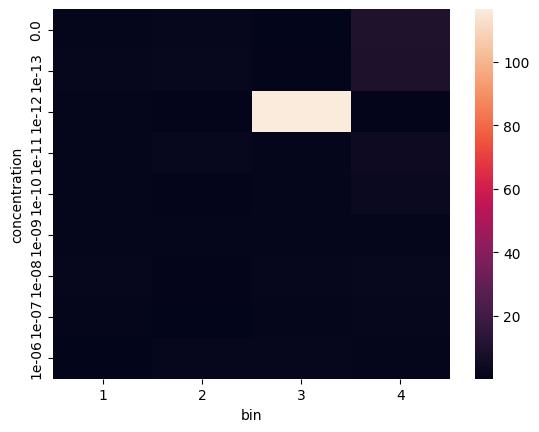

In [22]:
cells1 = counts_df.loc["lib1"].reset_index().pivot(index="concentration", columns="bin", values="number_cells")
cells2 = counts_df.loc["lib2"].reset_index().pivot(index="concentration", columns="bin", values="number_cells")

reads1 = counts_df.loc["lib1"].reset_index().pivot(index="concentration", columns="bin", values="number_reads")
reads2 = counts_df.loc["lib2"].reset_index().pivot(index="concentration", columns="bin", values="number_reads")

reads_per_cell1 = reads1 / cells1
reads_per_cell2 = reads2 / cells2

sns.heatmap(cells1)
plt.show()
sns.heatmap(cells2)
plt.show()

sns.heatmap(reads1)
plt.show()
sns.heatmap(reads2)
plt.show()

sns.heatmap(reads_per_cell1)
plt.show()
sns.heatmap(reads_per_cell2)
plt.show()

In [23]:
x = np.flip(concs)
logx = np.log(x)
libs = []
variants = []
variant_types = []
n_aa_substitutions = []
Y = []
bcs = []
Ynorm = []
for idx, ((lib, variant, n_aa_substitution), group_df) in enumerate(df_variants.groupby(["library", "variant", "n_aa_substitutions"])):
    y = group_df.read_count.values.reshape(len(x), -1)
    ynorm = group_df.estimated_cell_count.values.reshape(len(x), -1)
    libs.append(lib)
    variants.append(variant)
    if "*" in variant:
        variant_types.append("nonsense")
    elif variant != "WT":
        if n_aa_substitution == 1:
            variant_types.append(f"1 missense")
        elif n_aa_substitution > 1:
            variant_types.append(f">1 missense")
        else:
            raise ValueError
    else:
        variant_types.append("WT")
    n_aa_substitutions.append(n_aa_substitution)
    Y.append(y)
    assert len(group_df.barcode.unique()) == 1, group_df.barcode
    bcs.append(float(group_df.barcode.unique().squeeze()))
    Ynorm.append(ynorm)
libs = np.array(libs)
variants = np.array(variants)
variant_types = np.array(variant_types)
n_aa_substitutions = np.array(n_aa_substitutions)
Y = np.array(Y)
bcs = np.array(bcs)
Ynorm = np.array(Ynorm)

assert Y.shape == Ynorm.shape

Y.shape

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_76168/3065504854.py:2: RuntimeWarning: divide by zero encountered in log
  logx = np.log(x)


(19637, 9, 4)

Distribution of normalized read counts per variant

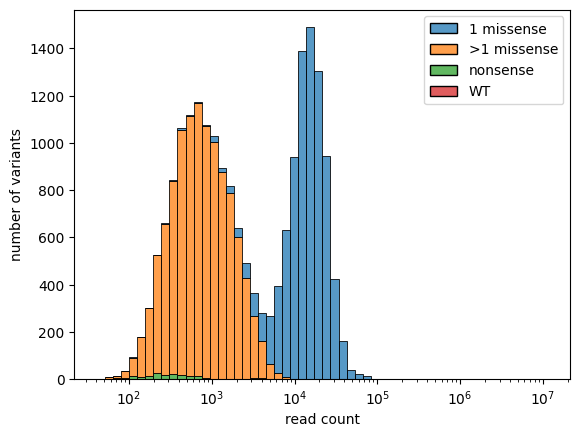

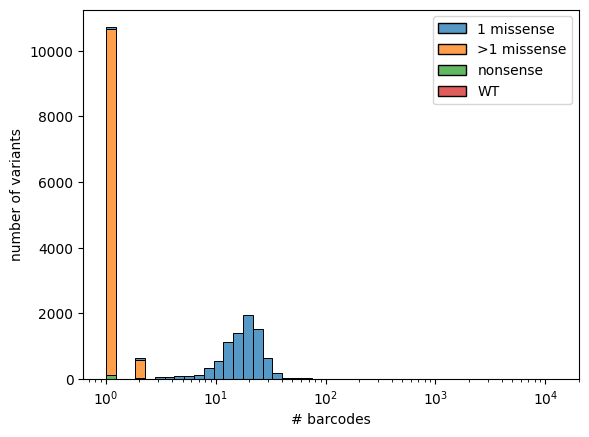

In [24]:
sns.histplot(x=Y.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("read count")
plt.ylabel("number of variants")
plt.show()

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()

Filter variants with low read counts

In [25]:
# filter_idxs = (n_aa_substitutions <= 1) & (Y.sum(-1) >= 10).all(-1) & (variant_types != "nonsense")
# filter_idxs = (n_aa_substitutions <= 1) & (Y.sum((1, 2)) >= 1000) & (variant_types != "nonsense")
filter_idxs = (Y.sum((1, 2)) >= 1000)
Y = Y[filter_idxs]
Ynorm = Ynorm[filter_idxs]
libs = libs[filter_idxs]
variants = variants[filter_idxs]
variant_types = variant_types[filter_idxs]
n_aa_substitutions = n_aa_substitutions[filter_idxs]
bcs = bcs[filter_idxs]

Y.shape

(12292, 9, 4)

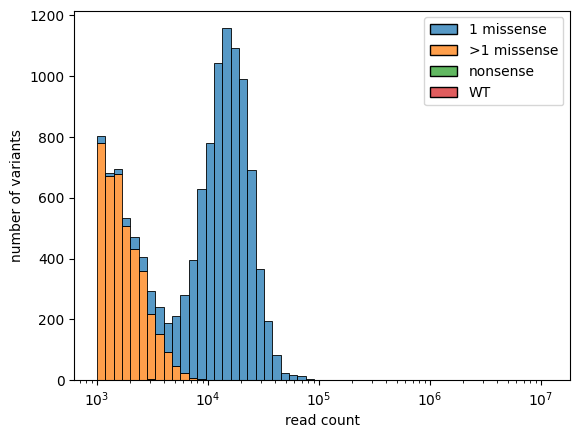

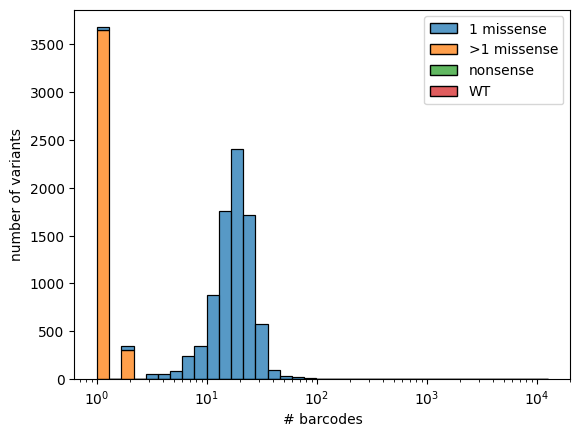

In [26]:
sns.histplot(x=Y.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("read count")
plt.ylabel("number of variants")
plt.show()

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()

indices of WT

In [27]:
wt_idx1, wt_idx2 = np.where(variants == "WT")[0]

libs[wt_idx1], variants[wt_idx1], libs[wt_idx2], variants[wt_idx2]

('lib1', 'WT', 'lib2', 'WT')

indices of libraries

In [28]:
lib1_idxs = np.where(libs == "lib1")[0]
lib2_idxs = np.where(libs == "lib2")[0]

Initialize parameters

In [29]:
def binfs_fn(df):
    result = pd.Series([np.log(df["PE-A"].loc[df["PE-A"] < b[1]]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[1]) & (df["PE-A"] < b[2])]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[2]) & (df["PE-A"] < b[3])]).mean(),
            np.log(df["PE-A"].loc[df["PE-A"] >= b[3]]).mean()],
            index=bins,
    )
    if pd.isna(result[1]):
        result[1] = np.log(b[1] / 2)
    if pd.isna(result[2]):
        result[2] = np.log(b[1] + (b[2] - b[1]) / 2)
    if pd.isna(result[3]):
        result[3] = np.log(b[2] + (b[3] - b[2]) / 2)
    if pd.isna(result[4]):
        result[4] = np.log(b[3] + (b[4] - b[3]) / 2)
    return result

binfs1 = fcs_df.query("library == 1").groupby("concentration").apply(binfs_fn).values
binfs2 = fcs_df.query("library == 2").groupby("concentration").apply(binfs_fn).values
binfs1, binfs2

/Users/wsdewitt/miniconda3/envs/jax-metal/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wsdewitt/miniconda3/envs/jax-metal/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([[ 3.67535567,  5.1029518 ,  8.84928666, 11.88986763],
        [ 3.8027649 ,  5.1255578 ,  9.66208456, 11.88986763],
        [ 3.96695796,  5.30006393,  7.83393444, 11.88986763],
        [ 4.05794371,  6.20638973,  8.06921064, 11.88986763],
        [ 4.21443269,  6.43628639,  8.79475605, 10.65593872],
        [ 3.94763998,  6.44813809,  9.27926545, 10.86366992],
        [ 3.96291979,  6.51484936,  9.23536877, 11.27990724],
        [ 4.02359372,  6.66549913,  9.19591443, 11.62314663],
        [ 3.56925577,  7.00021358,  9.3050182 , 11.68026997]]),
 array([[ 3.70144604,  5.10336554,  9.66208456, 11.88986763],
        [ 3.74420994,  5.12493838,  9.66208456, 11.88986763],
        [ 3.97271008,  5.27766209,  7.74602864, 11.88986763],
        [ 4.08805716,  6.20576978,  8.07307964, 11.88986763],
        [ 4.25937259,  6.39374475,  8.83492159, 10.65256475],
        [ 3.97367315,  6.43588833,  9.22710318, 10.87296893],
        [ 3.95195404,  6.52715668,  9.21514817, 11.30047172],
      

In [30]:
def mean_bin_fn(df):
    library = df.library.unique().squeeze()
    if library == "lib1":
        binfs = binfs1
    elif library == "lib2":
        binfs = binfs2
    else:
        raise ValueError(library)
    concentration = df.antigen_concentration.unique().squeeze()
    concentration_idx = np.where(x == concentration)[0].squeeze()
    return np.exp(np.average(binfs[concentration_idx], weights=df.estimated_cell_count))

mean_bin_barcodes = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "barcode", "antigen_concentration"]).apply(mean_bin_fn).to_frame().reset_index().rename(columns={0: "bin_based_fluorescence"})
mean_bin_variants = df_variants.groupby(["library", "variant", "n_aa_substitutions", "antigen_concentration"]).apply(mean_bin_fn).to_frame().reset_index().rename(columns={0: "bin_based_fluorescence"})

display(mean_bin_barcodes)
display(mean_bin_variants)

,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin_based_fluorescence
0,lib1,A104C,1,AAAACACTATCTAGGA,0.000000e+00,41.120160
1,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-13,44.824950
2,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-12,57.853982
3,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-11,525.080754
4,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-10,4709.793081
...,...,...,...,...,...,...
1398109,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-10,598.092095
1398110,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-09,14571.907049
1398111,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-08,23843.684991
1398112,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-07,51924.784913


,library,variant,n_aa_substitutions,antigen_concentration,bin_based_fluorescence
0,lib1,A104C,1,0.000000e+00,40.549972
1,lib1,A104C,1,1.000000e-13,46.202329
2,lib1,A104C,1,1.000000e-12,64.506551
3,lib1,A104C,1,1.000000e-11,437.484952
4,lib1,A104C,1,1.000000e-10,5152.052021
...,...,...,...,...,...
176728,lib2,Y94W R145M,2,1.000000e-10,598.092095
176729,lib2,Y94W R145M,2,1.000000e-09,14571.907049
176730,lib2,Y94W R145M,2,1.000000e-08,23843.684991
176731,lib2,Y94W R145M,2,1.000000e-07,51924.784913


/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_76168/1470263336.py:10: RuntimeWarning: divide by zero encountered in log
  logx_grid = np.log(x_grid)
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_76168/1470263336.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(b[0], b[-1])


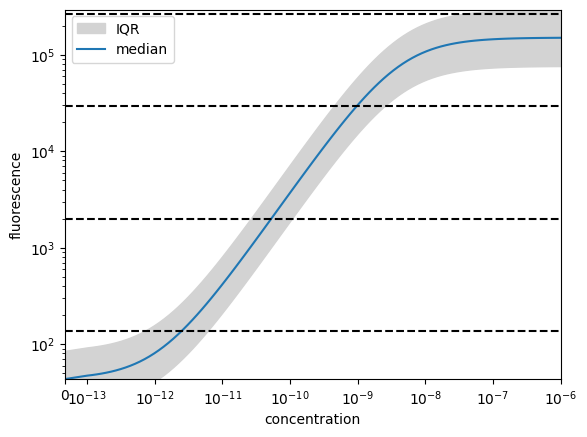

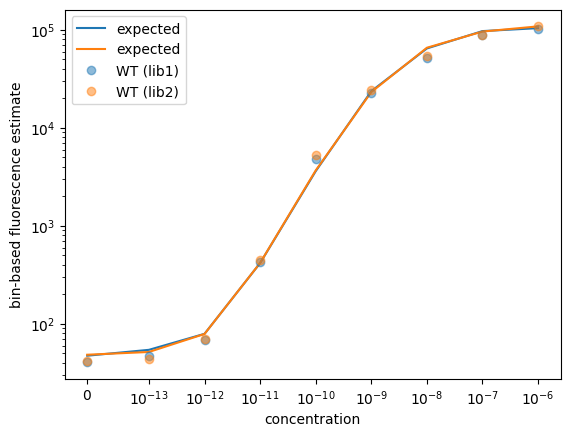

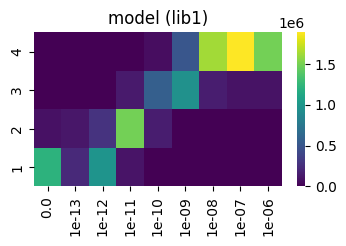

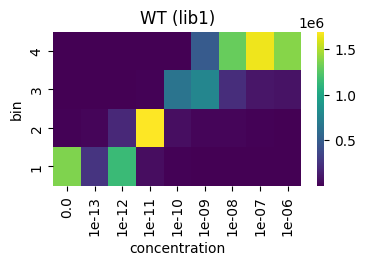

In [31]:
logα = np.log(1.5e5)
logKd = np.log(4e-9)
logσ = -0.

logβ = np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].median())

logγ = np.log(bcs[wt_idx1] / bcs[lib1_idxs].sum())

x_grid = np.array([0] + list(np.logspace(np.log10(x[1]), np.log10(x[-1]), 100)))
logx_grid = np.log(x_grid)
fs = f(logx_grid, logα, logβ, logKd)
scale = np.exp(logσ)
q25 = scipy.stats.lognorm.ppf(0.25, s=scale, scale=fs)
q75 = scipy.stats.lognorm.ppf(0.75, s=scale, scale=fs)
plt.fill_between(x_grid,
                 q25,
                 q75,
                 color="lightgray",
                 label="IQR")
plt.plot(x_grid, fs, label="median")
for b_ in b:
    plt.axhline(b_, color="k", linestyle="--")
plt.xscale("symlog", linthresh=x[1], linscale=0.3)
plt.yscale("log")
plt.ylim(b[0], b[-1])
plt.xlabel("concentration")
plt.ylabel("fluorescence")
plt.xlim(x[0], x[-1])
plt.ylim(fs[0], q75[-1])
plt.legend()
plt.show()

ps = p(logx, logα, logβ, logKd, b, logσ)
mean_binf1 = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf2 = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt1 = np.exp((binfs1 * Ynorm[wt_idx1]).sum(1) / Ynorm[wt_idx1].sum(1))
mean_binf_wt2 = np.exp((binfs2 * Ynorm[wt_idx2]).sum(1) / Ynorm[wt_idx2].sum(1))

plt.plot(x, mean_binf1, label="expected", c="C0")
plt.plot(x, mean_binf2, label="expected", c="C1")
plt.plot(x, mean_binf_wt1, "o", label="WT (lib1)", alpha=0.5, c="C0")
plt.plot(x, mean_binf_wt2, "o", label="WT (lib2)", alpha=0.5, c="C1")
plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()

logps = logp(logx, logα, logβ, logKd, b, logσ)

# expected read count matrix
exp_cell_df = pd.DataFrame((reads_per_cell1 * cells1.values.sum(1, keepdims=True) * np.exp(logγ + logps)).T, columns=x, index=bins)
plt.figure(figsize=(4, 2))
ax = sns.heatmap(exp_cell_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"model (lib1)")
plt.show()

read_df = pd.DataFrame(Y[wt_idx1].T, columns=pd.Series(x, name="concentration"), index=pd.Series(bins, name="bin"))
plt.figure(figsize=(4, 2))
ax = sns.heatmap(read_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"WT (lib1)")
plt.show()

A simulation demonstration showing how amplitude and $K_D$ are confounded in mean-bin modeling

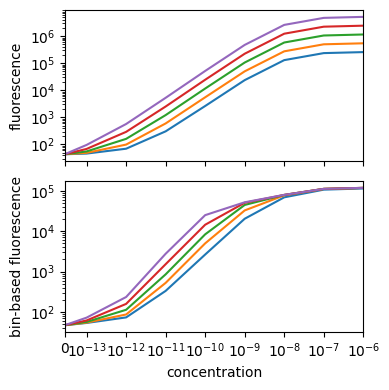

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(4, 4), sharex=True, sharey=False)
for logα_ in np.log(b[-1]) + np.linspace(0, 3, 5):
    logKd_ = np.log(1e-8)
    fs = f(logx, logα_, logβ, logKd_)
    axs[0].plot(x, fs)
    ps = p(logx, logα_, logβ, logKd_, b, logσ)
    mean_binf = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
    axs[1].plot(x, mean_binf)
axs[0].set_yscale("log")
axs[0].set_ylabel("fluorescence")
axs[1].set_xscale("symlog", linthresh=1e-13, linscale=0.5)
axs[1].set_xlim(concs[-1], concs[0])
axs[1].set_yscale("log")
axs[1].set_xlabel("concentration")
axs[1].set_ylabel("bin-based fluorescence")
plt.tight_layout()
plt.show()

Loss surface for WT

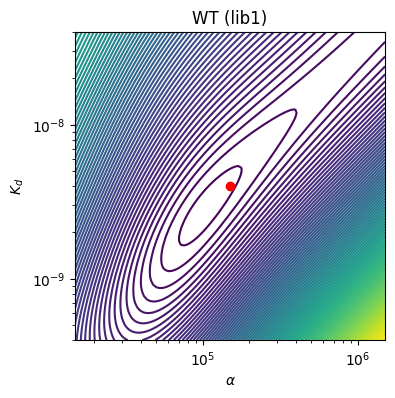

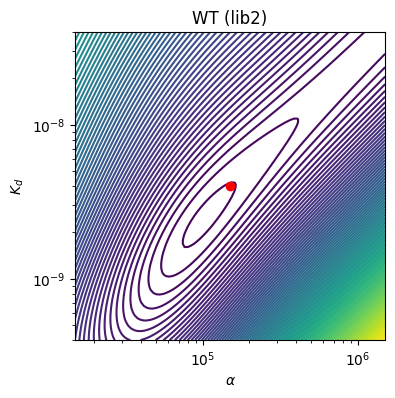

In [33]:
for ct, (wt_idx, logf_pdfs, binfs) in enumerate(zip((wt_idx1, wt_idx2),
                                                    (logf_pdfs1, logf_pdfs2),
                                                    (binfs1, binfs2)),
                                                          1):
    # plot loss surface for Kd and α on one sample
    αs = np.exp(logα) * np.logspace(-1, 1, 100)
    Kds = np.exp(logKd) * np.logspace(-1, 1, 100)
    # αs, Kds = np.meshgrid(αs, Kds)
    loss = np.zeros((Kds.shape[0], αs.shape[0]))
    for i in range(Kds.shape[0]):
        for j in range(αs.shape[0]):
            # loss[i, j] = one_neg_log_likelihood(np.log(αs[j]), np.log(Kds[i]), Y[wt_idx], bcs[wt_idx], logλ, logφ, logβ, logσ, logx, b)
            
            # neg_log_likelihood((logβ, logσ, jnp.array([np.log(αs[j])]), jnp.array([np.log(Kds[i])]), logλ, logφ),
                                            # (jnp.array([Y[wt_idx]]), logx, b))    
            # loss[i, j] = one_mean_bin_loss(np.log(αs[j]), np.log(Kds[i]), Ynorm[wt_idx],
            #                                logβ, logσ, logx, b, binfs,
            #                                )
            loss[i, j] = one_neg_log_likelihood(logγ, np.log(αs[j]), np.log(Kds[i]), Y[wt_idx],
                                                logβ, logσ, logx, b, cells1.values, reads_per_cell1.values)

    plt.figure(figsize=(4, 4))
    plt.contour(αs, Kds, loss, levels=100)
    plt.plot(np.exp(logα), np.exp(logKd), "o", color="r")
    plt.xlabel("$\\alpha$")
    plt.ylabel("$K_d$")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"WT (lib{ct})")
    plt.show()

Form data and params for optimizations

In [34]:
single_mut_idxs = (n_aa_substitutions == 1) & (variant_types != "nonsense")
other_mut_idxs = (n_aa_substitutions > 1) | (variant_types == "nonsense")

assert sum(single_mut_idxs) + sum(other_mut_idxs) == len(n_aa_substitutions) - 2

In [555]:
data1 = Y[lib1_idxs], wt_idx1, logx, b, cells1.values.sum(1), reads_per_cell1.values, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"]).median(), logf_grid, logf_pdfs1, np.where(single_mut_idxs[lib1_idxs])[0], np.where(other_mut_idxs[lib1_idxs])[0]
data2 = Y[lib2_idxs], wt_idx2 - len(lib1_idxs), logx, b, cells2.values.sum(1), reads_per_cell2.values, np.log(fcs_df.query("library == 2 & concentration == 0")["PE-A"]).median(), logf_grid, logf_pdfs2, np.where(single_mut_idxs[lib2_idxs])[0], np.where(other_mut_idxs[lib2_idxs])[0]

# data1 = Ynorm[lib1_idxs], logx, b, binfs1, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].mean()), logf_grid, logf_pdfs1
# data2 = Ynorm[lib2_idxs], logx, b, binfs2, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].mean()), logf_grid, logf_pdfs2
# data1 = Ynorm[lib1_idxs], logx, b, binfs1, wt_idx1
# data2 = Ynorm[lib2_idxs], logx, b, binfs2, wt_idx2 - len(lib1_idxs)

# data1 = (Y[lib1_idxs], bcs[lib1_idxs], logx, b)
# data2 = (Y[lib2_idxs], bcs[lib2_idxs], logx, b)

/Users/wsdewitt/miniconda3/envs/jax-metal/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wsdewitt/miniconda3/envs/jax-metal/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [556]:
# # αs, Kds
# @jax.jit
# @jax.value_and_grad
# def loss_block1(αKd, params, data, **kwargs):
#     params[:2] = αKd
#     return mean_bin_loss(params, data, **kwargs)

# # σ
# @jax.jit
# @jax.value_and_grad
# def loss_block2(σ, params, data, **kwargs):
#     params[2] = σ
#     return mean_bin_loss(params, data, **kwargs)

$$
p(z\mid \alpha, \beta, K_D, \sigma^2)
$$

$$
\begin{align*}
p(\alpha, \beta, \gamma, \kappa, \sigma, Z, Y) &= p(\alpha, \beta, \gamma, \kappa, \sigma \mid Z, Y) \ p(Z, Y)\\
&= p(\alpha, \beta, \gamma, \kappa, \sigma \mid z, y) \ p(Y \mid Z) p(Z)
\end{align*}
$$

In [557]:
opt = jaxopt.ScipyBoundedMinimize(
    fun=neg_log_likelihood,
    method="l-bfgs-b",
    # projection=jaxopt.projection.projection_box,
    # value_and_grad=True,
    maxiter=200, tol=1e-2,
    options=dict(maxls=20,
                 maxcor=10,
                 ftol=0,
                 gtol=0,
                #  iprint=1,
                 ),
    # acceleration=False,
    # linesearch="zoom",
    # maxls=50,
    # linesearch_init="max",
    # stepsize=0.01,
    # max_stepsize=1e2, min_stepsize=1e-4,
    # history_size=100,
    # verbose=True,
    jit=True,
)

In [558]:
params1 = [jnp.log(bcs[lib1_idxs] / bcs[lib1_idxs].sum()),
           logα * jnp.ones(len(lib1_idxs)),
           logKd * jnp.ones(len(lib1_idxs)),
           jnp.asarray(logσ),
           ]
params2 = [jnp.log(bcs[lib2_idxs] / bcs[lib2_idxs].sum()),
           logα * jnp.ones(len(lib2_idxs)),
           logKd * jnp.ones(len(lib2_idxs)),
           jnp.asarray(logσ),
           ]

In [559]:
def bounds(params):
    lb = [
          jnp.full_like(params[0], -15),
          jnp.full_like(params[1], logα - 6),
          jnp.full_like(params[2], jnp.log(1e-12)),
          jnp.array(-0.75),
          ]
    ub = [
          jnp.full_like(params[0], 0),
          jnp.full_like(params[1], logα + 6),
          jnp.full_like(params[2], jnp.log(1e-4)),
          jnp.array(0.75),
          ]
    return lb, ub

In [560]:
neg_log_likelihood(params1, data1), neg_log_likelihood(params2, data2)

(Array(-103444.5151042, dtype=float64), Array(-85292.44159284, dtype=float64))

In [592]:
λ1 = 1e-3
λ2 = 1e-3
for μ in np.logspace(-3, 3, 10):
# for μ in (1e2,):
    print(f"{μ=:.1e}")

    γ_ridge = 1e-3
    α_ridge = 1e-3
    Kd_ridge = 1e-3

    print(f"  {λ1=:.1e}")
    params1, state1 = opt.run(
        params1,
        bounds(params1),
        data1,
        μ=μ, λ=λ1,
        γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge,
        )
    D1 = DKL(params1, data1)
    λ1 += μ * D1
    error1 = opt.l2_optimality_error(params1,
                                     bounds(params1),
                                     data1, μ=μ, λ=λ1, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    obj1 = neg_log_likelihood(params1, data1, μ=μ, λ=λ1, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    print(f"    {state1.iter_num} iterations")
    print(f"    error={error1:.2e}")
    print(f"    obj={obj1:.2e}")
    print(f"    DKL={D1:.2e}")

    print(f"  {λ2=:.1e}")
    params2, state2 = opt.run(
        params2,
        bounds(params2),
        data2,
        μ=μ, λ=λ2,
        γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge,
        )
    D2 = DKL(params2, data2)
    λ2 += μ * D2
    error2 = opt.l2_optimality_error(params2,
                                     bounds(params2),
                                     data2, μ=μ, λ=λ2, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    obj2 = neg_log_likelihood(params2, data2, μ=μ, λ=λ2, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    print(f"    {state2.iter_num} iterations")
    print(f"    error={error2:.2e}")
    print(f"    obj={obj2:.2e}")
    print(f"    DKL={D2:.2e}")

μ=1.0e+03
  λ1=7.9e+01
    200 iterations
    error=4.13e+00
    obj=-1.04e+05
    DKL=4.97e-01
  λ2=9.4e+01
    200 iterations
    error=3.55e+00
    obj=-8.60e+04
    DKL=5.73e-01


In [611]:
params1, params2

([Array([ -8.36201359, -10.81545733,  -7.9006098 , ..., -10.77351096,
         -11.13988353,  -7.85273242], dtype=float64),
  Array([11.53510051, 10.43554792, 11.22439043, ..., 11.99709275,
         11.92868907, 11.24449554], dtype=float64),
  Array([-19.77749713, -18.11837229, -19.48387297, ..., -18.4872534 ,
         -19.98290582, -19.33995441], dtype=float64),
  Array(-0.21775607, dtype=float64)],
 [Array([ -8.74754018,  -8.01176027,  -8.33330073, ...,  -7.9239535 ,
         -10.71842193,  -7.42262733], dtype=float64),
  Array([11.73301836, 11.43769681, 11.69121879, ..., 11.70968374,
         11.97062231, 11.22412295], dtype=float64),
  Array([-19.66524226, -19.30939796, -19.38412435, ..., -20.68356264,
         -19.98936309, -19.48976999], dtype=float64),
  Array(-0.23112639, dtype=float64)])

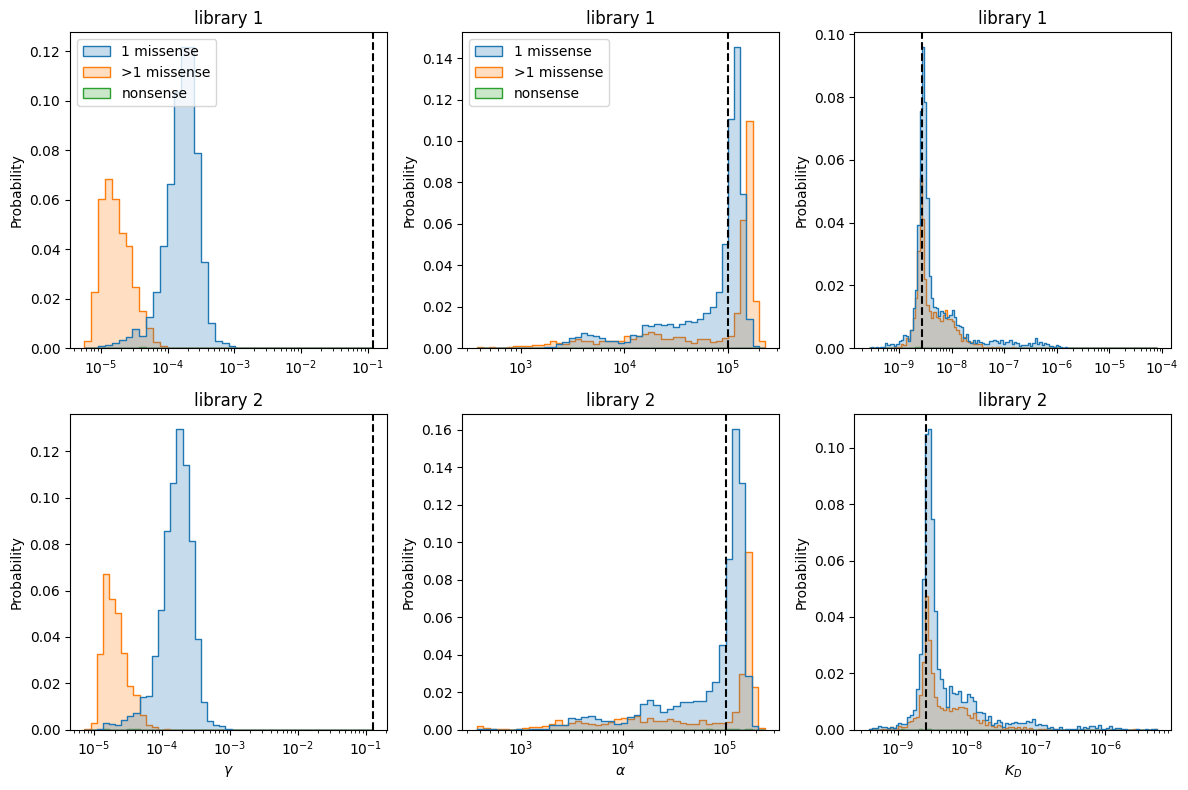

In [612]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
sns.histplot(x=np.exp(params1[0]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             )
plt.axvline(np.exp(params1[0][wt_idx1]), color="k", linestyle="--")
plt.title("library 1")
plt.subplot(234)
sns.histplot(x=np.exp(params2[0]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[0][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\\gamma$")
plt.subplot(232)
sns.histplot(x=np.exp(params1[1]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             )
plt.axvline(np.exp(params1[1][wt_idx1]), color="k", linestyle="--")
plt.title("library 1")
plt.subplot(235)
sns.histplot(x=np.exp(params2[1]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[1][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\\alpha$")
plt.subplot(233)
sns.histplot(x=np.exp(params1[2]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(-12, -5, 100),
             element="step",
             legend=False,
             )
plt.title("library 1")
plt.axvline(np.exp(params1[2][wt_idx1]), color="k", linestyle="--")
plt.subplot(236)
sns.histplot(x=np.exp(params2[2]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(-12, -5, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[2][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$K_D$")
plt.tight_layout()
plt.show()

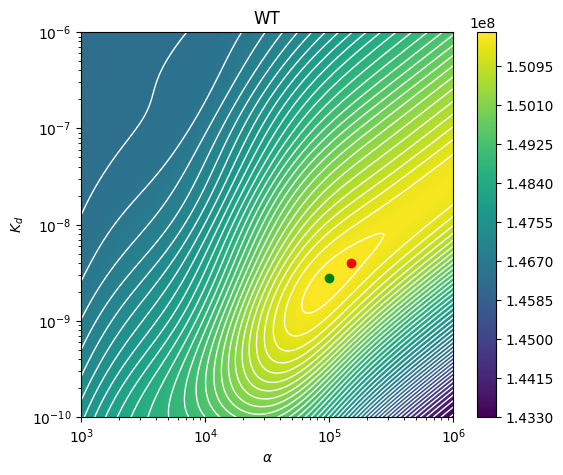

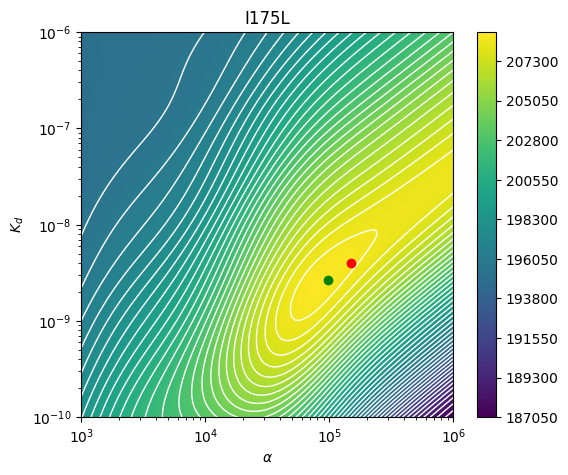

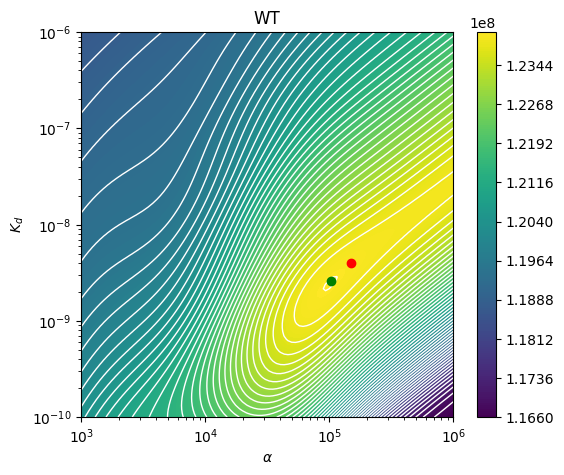

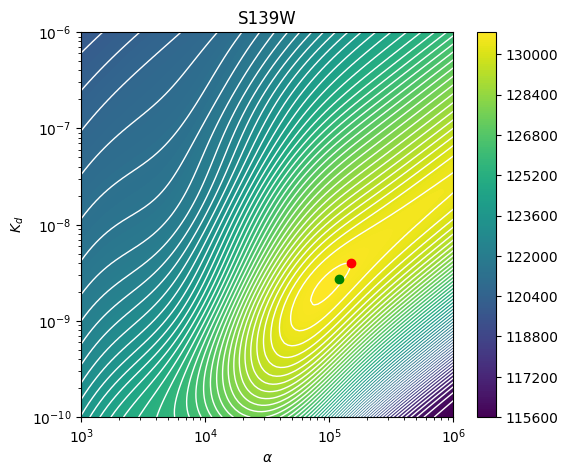

In [613]:
for datai, paramsi, wt_idxi, variantsi, variant_typesi in zip((data1, data2),
                                      (params1, params2),
                                      (wt_idx1, wt_idx2 - len(lib1_idxs)),
                                      (variants[lib1_idxs], variants[lib2_idxs]),
                                      (variant_types[lib1_idxs], variant_types[lib2_idxs]),
                                      ):
    Yi = datai[0].copy()
    logβi = datai[6]
    logγi = paramsi[0].copy()
    logσi = paramsi[3]
    cellsi = datai[4].copy()
    reads_per_celli = datai[5].copy()
    αs = np.logspace(3, 6, 100)
    Kds = np.logspace(-10, -6, 100)
    for var_idx in (wt_idxi, np.random.choice(np.where(variant_typesi == "1 missense")[0], 1)[0]):
    # for var_idx in (wt_idxi, np.random.choice(np.where(variantsi == "F198N")[0], 1)[0]):
        # plot loss surface for Kd and α on one sample
        # αs, Kds = np.meshgrid(αs, Kds)
        loss = np.zeros((Kds.shape[0], αs.shape[0]))
        for i in range(Kds.shape[0]):
            for j in range(αs.shape[0]):
                # loss[i, j] = neg_log_likelihood((logβ, logσ, logγ, logφ, np.log(αs[j]), np.log(Kds[i]), logλs[0]),
                #                                (y, logx, b))        
                loss[i, j] = -one_neg_log_likelihood(logγi[var_idx], np.log(αs[j]), np.log(Kds[i]), Yi[var_idx],
                                                    logβi, logσi, logx, b, cellsi, reads_per_celli)


        plt.figure(figsize=(6, 5))
        plt.contourf(αs, Kds, loss, levels=200, alpha=1.0)
        plt.colorbar()
        plt.contour(αs, Kds, loss, levels=50, linestyles="solid", linewidths=1, colors="w")
        plt.plot(np.exp(logα), np.exp(logKd), "o", color="r")
        plt.plot(np.exp(paramsi[1][var_idx]), np.exp(paramsi[2][var_idx]), "o", color="g")
        plt.xlabel("$\\alpha$")
        plt.ylabel("$K_d$")
        plt.xscale("log")
        plt.yscale("log")
        plt.title(variantsi[var_idx])
        plt.show()

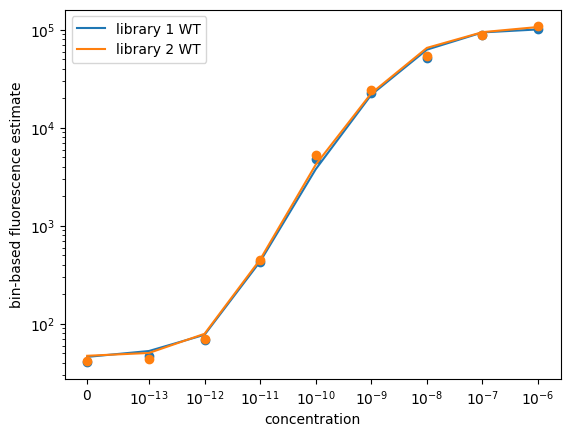

In [614]:
ps = p(logx, params1[1][wt_idx1], data1[6], params1[2][wt_idx1], b, params1[3])
mean_binf = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs1 * Ynorm[wt_idx1]).sum(1) / Ynorm[wt_idx1].sum(1))
plt.plot(x, mean_binf, c="C0", label="library 1 WT")
plt.plot(x, mean_binf_wt, "o", c="C0")
ps = p(logx, params2[1][wt_idx2 - len(lib1_idxs)], data2[6], params2[2][wt_idx2 - len(lib1_idxs)], b, params2[3])
mean_binf = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs2 * Ynorm[wt_idx2]).sum(1) / Ynorm[wt_idx2].sum(1))
plt.plot(x, mean_binf, c="C1", label="library 2 WT")
plt.plot(x, mean_binf_wt, "o", c="C1")
""
plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()

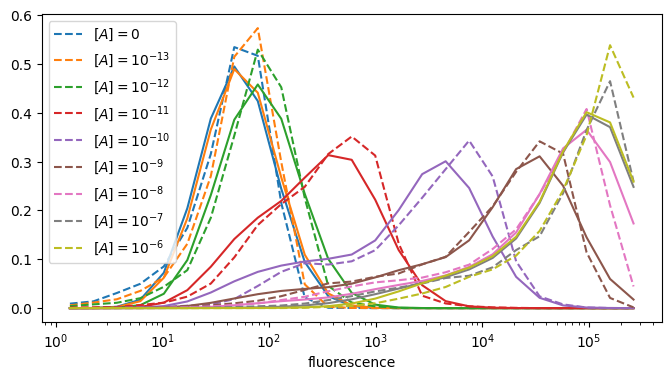

In [615]:
plt.figure(figsize=(8, 4))
for i, logxi in enumerate(logx):
    fs = f(logxi, params1[1], data1[6], params1[2])
    curve = scipy.stats.norm.pdf(logf_grid, loc=jnp.log(fs[:, None]), scale=np.exp(params1[3])).mean(0)
    curve = curve / jax.scipy.integrate.trapezoid(curve, x=logf_grid)
    plt.plot(np.exp(logf_grid), curve, c=f"C{i}")
    if i == 0:
        label = "$[A]=0$"
    else:
        label = f"$[A]=10^{{{int(np.log10(x[i])):1d}}}$"
    plt.plot(np.exp(logf_grid), logf_pdfs1[i], c=f"C{i}", ls="--", label=label)
plt.xscale("log")
plt.xlabel("fluorescence")
plt.legend()
plt.show()

In [616]:
Kd_variants = pd.DataFrame({"library": libs,
                            "variant": variants,
                            "n_aa_substitutions": n_aa_substitutions,
                            "variant_type": variant_types,
                            })
Kd_variants.loc[lib1_idxs, "library_fraction"] = np.exp(params1[0])
Kd_variants.loc[lib2_idxs, "library_fraction"] = np.exp(params2[0])
Kd_variants.loc[lib1_idxs, "expression"] = np.exp(params1[1])
Kd_variants.loc[lib2_idxs, "expression"] = np.exp(params2[1])
Kd_variants.loc[lib1_idxs, "log10Kd"] = np.array(params1[2]) / np.log(10)
Kd_variants.loc[lib2_idxs, "log10Kd"] = np.array(params2[2]) / np.log(10)

for lib in ("lib1", "lib2"):
    Kd_variants.loc[Kd_variants.library==lib, f"delta_log10Ka"] = Kd_variants.loc[(Kd_variants.library==lib) & (Kd_variants.variant=="WT"), "log10Kd"].squeeze() - Kd_variants.loc[Kd_variants.library==lib, "log10Kd"]

Kd_variants

,library,variant,n_aa_substitutions,variant_type,library_fraction,expression,log10Kd,delta_log10Ka
0,lib1,A104C,1,1 missense,0.000234,102242.273757,-8.589258,0.029805
1,lib1,A104C G105V,2,>1 missense,0.000020,34048.726943,-7.868709,-0.690743
2,lib1,A104D,1,1 missense,0.000371,74936.054834,-8.461739,-0.097714
3,lib1,A104E,1,1 missense,0.000150,124359.431046,-8.401986,-0.157466
4,lib1,A104E S203G,2,>1 missense,0.000012,156958.951074,-8.576554,0.017102
...,...,...,...,...,...,...,...,...
12287,lib2,Y94S,1,1 missense,0.000376,77788.317746,-8.991051,0.404789
12288,lib2,Y94T,1,1 missense,0.000685,84176.207871,-9.194545,0.608284
12289,lib2,Y94V,1,1 missense,0.000362,121744.972186,-8.982757,0.396496
12290,lib2,Y94V G113C,2,>1 missense,0.000022,158042.982221,-8.681270,0.095009


In [617]:
Kd_variants.query("variant == 'WT'").log10Kd

5972    -8.559453
11843   -8.586261
Name: log10Kd, dtype: float64

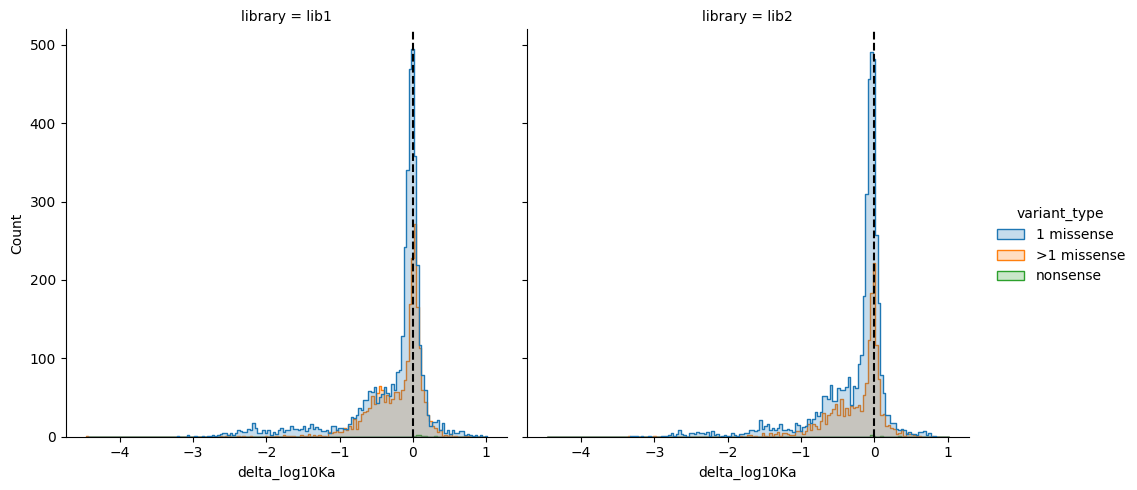

In [618]:
g = sns.displot(Kd_variants,
                x="delta_log10Ka", col="library", hue="variant_type",
                hue_order=("1 missense", ">1 missense", "nonsense"),
                # bins=40,
                element="step"
                )
g.axes[0, 0].axvline(0, color="k", linestyle="--")
g.axes[0, 1].axvline(0, color="k", linestyle="--")
plt.show()

Show some titration curve fits

In [619]:
plot_variants = pd.Series([
                           "F225D",
                           "Y176T",
                           "V160D",
                           "I129H",
                           "Q16W",
                           "L4T",
                           ])
plot_variants

0    F225D
1    Y176T
2    V160D
3    I129H
4     Q16W
5      L4T
dtype: object

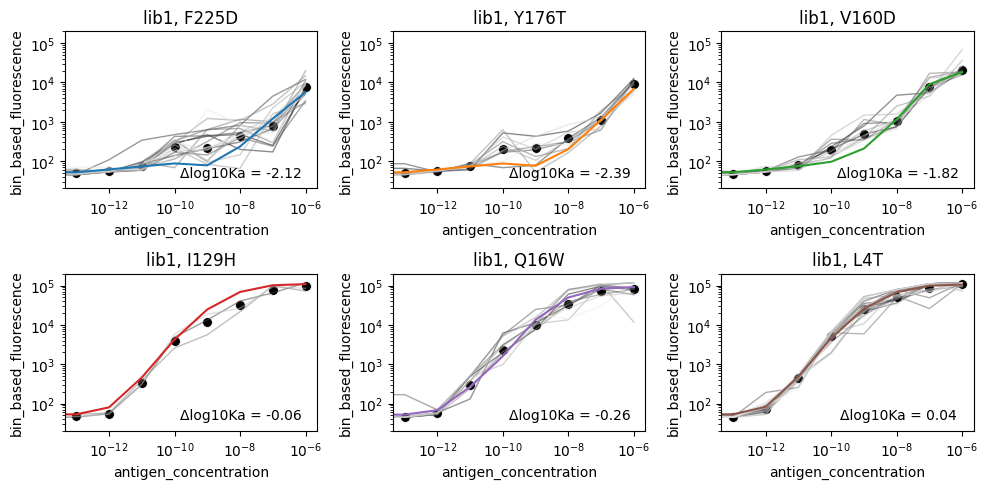

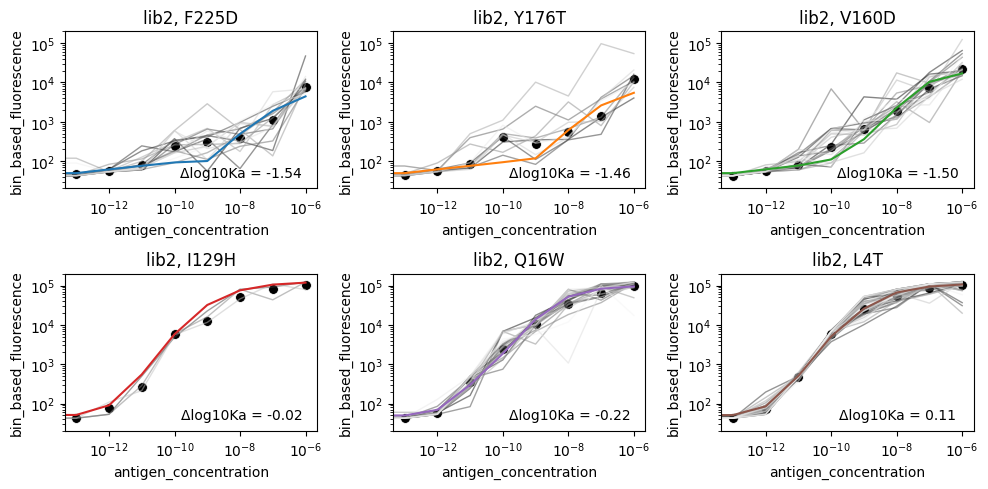

In [620]:
for library, params, data, lib_idxs in zip(
    ("lib1", "lib2"),
    (params1, params2),
    (data1, data2),
    (lib1_idxs, lib2_idxs),
    ):
    plt.figure(figsize=(10, 5))
    for i, variant in enumerate(plot_variants):
        plt.subplot(2, 3, i + 1)
        plt.title(f"{library}, {variant}")
        sns.lineplot(data=mean_bin_barcodes.query("(library == @library) & (variant == @variant)"),
                    x="antigen_concentration", y="bin_based_fluorescence", hue="barcode",
                    palette="gray", lw=1,
                    alpha=0.5,
                    legend=False,
                    )
        sns.scatterplot(data=mean_bin_variants.query("(library == @library) & (variant == @variant)"),
                    x="antigen_concentration", y="bin_based_fluorescence",
                    color="k", alpha=1.0,
                    s=50,
                    )
        plt.annotate(f"Δlog10Ka = {Kd_variants.query('(library == @library) & (variant == @variant)').delta_log10Ka.squeeze():.2f}",
                    xy=(0.7, 0.1), xycoords="axes fraction",
                    ha="center", va="center",
                    )
        variant_idx = list(variants[lib_idxs]).index(variant)
        ps = p(logx, params[1][variant_idx], data[6], params[2][variant_idx], b, params[3])
        if library == "lib1":
            binfs = binfs1
        elif library == "lib2":
            binfs = binfs2
        else:
            raise ValueError(library)
        mean_bins = np.exp((binfs * ps).sum(1) / ps.sum(1))
        plt.plot(x, mean_bins, color=f"C{i}")
        plt.ylim(20, 2e5)
        plt.xscale("log")
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

$\log_{10} K_A$ correlation

Number of variants: 8147


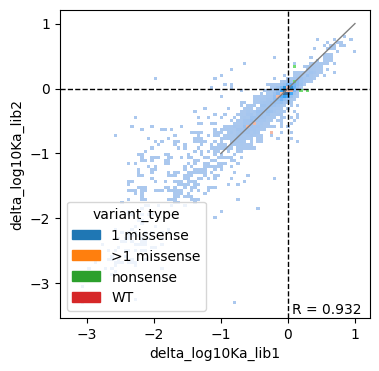

In [621]:
pivoted = Kd_variants.pivot(index="variant", columns="library")
print(f"Number of variants: {len(pivoted)}")
pivoted.columns = pivoted.columns.map("_".join)
pivoted.drop("variant_type_lib2", axis=1, inplace=True)
pivoted.rename(columns={"variant_type_lib1": "variant_type"}, inplace=True)
hist_bins = np.linspace(-2, 1, 100)
plt.figure(figsize=(4, 4))
sns.histplot(data=pivoted,
              x="delta_log10Ka_lib1",
              y="delta_log10Ka_lib2",
              hue="variant_type",
              # hue_order=("1 missense", ">1 missense", "nonsense"),
              )
pearson_cor_r = pearsonr(*pivoted[['delta_log10Ka_lib1', 'delta_log10Ka_lib2']].dropna().values.T).statistic
plt.annotate(f"R = {pearson_cor_r:.3f}",
                (0.75, 0.05), xycoords="axes fraction", ha="left", va="top")
plt.plot([-1, 1], [-1, 1], color="gray", lw=1)
plt.axvline(0, color="black", lw=1, ls="--")
plt.axhline(0, color="black", lw=1, ls="--")
# plt.xlim(-2, 1)
# plt.ylim(-2, 1)
plt.show()

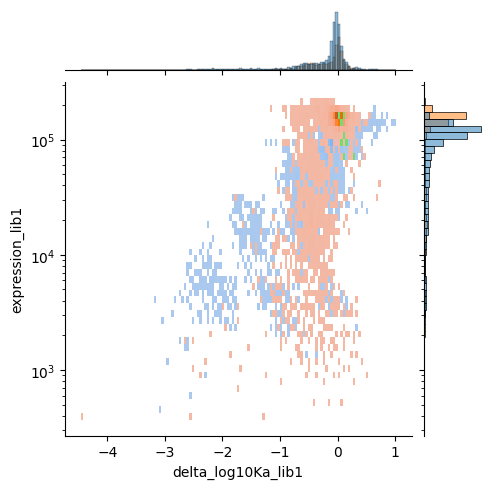

In [622]:
g = sns.jointplot(data=pivoted,
              x="delta_log10Ka_lib1",
              y="expression_lib1",
              hue="variant_type",
              # hue_order=("1 missense", ">1 missense", "nonsense"),
            #   joint_kws=dict(bins=(hist_bins, hist_bins)),
            #   marginal_kws=dict(bins=hist_bins),
              kind="hist",
              log_scale=(False, True),
              legend=False,
              height=5)
# sns.move_legend(g, loc="upper left")

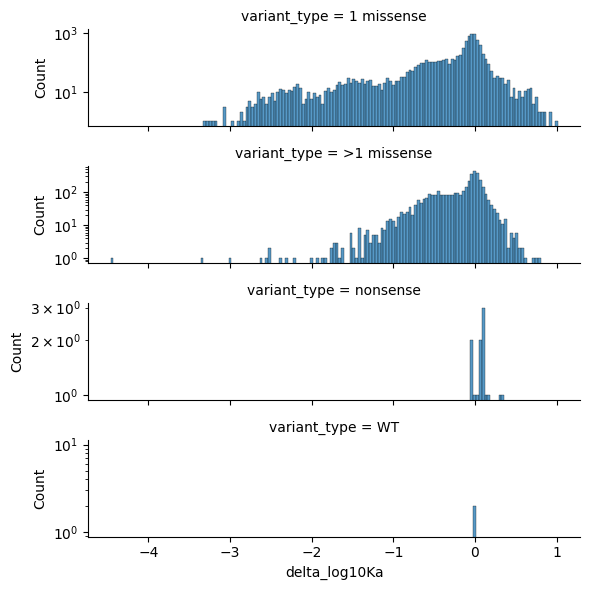

In [623]:
sns.displot(data=Kd_variants,
             x="delta_log10Ka", row="variant_type",
             multiple="stack",
            #  row_order=["WT", "1", "2", "3", "4", "nonsense"],
            #  bins=30,
             common_norm=False, facet_kws=dict(sharey=False),
             log=True,
             height=1.5, aspect=4)      

### IMGT numbering

Note: mutation names may be different, check with Ashni

In [624]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [625]:
def imgt_fn(variant):
    if variant == "WT":
        return "WT"
    wt = variant[0]
    site_scFv = int(variant[1:-1])
    mut = variant[-1]
    return f"{wt}{pos_df.site[site_scFv]}({pos_df.chain[site_scFv]}){mut}"

In [661]:
output_df = Kd_variants.query("variant_type in ('WT', '1 missense')").copy()
output_df["variant"] = output_df.variant.apply(imgt_fn)
output_df

,library,variant,n_aa_substitutions,variant_type,library_fraction,expression,log10Kd,delta_log10Ka
0,lib1,A120(H)C,1,1 missense,0.000234,102242.273757,-8.589258,0.029805
2,lib1,A120(H)D,1,1 missense,0.000371,74936.054834,-8.461739,-0.097714
3,lib1,A120(H)E,1,1 missense,0.000150,124359.431046,-8.401986,-0.157466
6,lib1,A120(H)F,1,1 missense,0.000158,121706.998217,-8.549504,-0.009949
7,lib1,A120(H)G,1,1 missense,0.000239,120687.209458,-8.474881,-0.084571
...,...,...,...,...,...,...,...,...
12286,lib2,Y103(H)R,1,1 missense,0.000375,51108.483871,-8.817882,0.231620
12287,lib2,Y103(H)S,1,1 missense,0.000376,77788.317746,-8.991051,0.404789
12288,lib2,Y103(H)T,1,1 missense,0.000685,84176.207871,-9.194545,0.608284
12289,lib2,Y103(H)V,1,1 missense,0.000362,121744.972186,-8.982757,0.396496


## Octet data

In [756]:
octet_df = pd.read_csv("data/torchdms/raw-dms/octet_data.csv")
octet_df.columns = octet_df.columns.str.strip()
octet_df

,ID,HCmut,LCmut,aa_mut_total,deltaKd_additive_foldchange,deltaKd_additive,octet_Kd_foldchange_avg,kd,kon,kdis,R^2
0,#26 Fab4,"K49R, Y58F",A40G,3,7.462082,0.87286,6.364276,2.840000e-09,126300,0.000359,0.9993
1,A40G,GL,A40G,1,7.172326,0.85566,6.952912,4.210000e-09,90900,0.000383,0.9997
2,A40V,GL,A40V,1,0.193201,-0.71399,0.642593,5.400000e-08,142000,0.007670,0.9746
3,"A40V, N108D",GL,"A40V, N108D",2,0.031422,-1.50277,0.376934,7.110000e-08,111000,0.007920,0.9266
4,D28A,D28A,GL,1,6.835810,0.83479,5.774278,3.810000e-09,225000,0.000858,0.9944
5,EH1,"D28A, K44R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2558.998315,3.40807,308.192458,7.690000e-11,933000,0.000072,0.9919
6,EH2,"D28A, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",8,2154.269337,3.33330,383.495146,6.180000e-11,1030000,0.000063,0.9947
7,EH3,"D28A, K44R, K49R, S64G","A40G, Y42F, A52S, Q105H, N108Y",9,2499.769702,3.39790,361.280488,6.560000e-11,1050000,0.000069,0.9900
8,GL,GL,GL,0,1.000000,0.00000,1.000000,2.600000e-08,86700,0.002260,0.9900
9,K44R,K44R,GL,1,1.160379,0.06460,0.986547,2.230000e-08,152000,0.003400,0.9950


In [757]:
def mut_formatter(HCmut, chain):
    if HCmut == "GL":
        return "WT"
    HCmut = HCmut.replace(", ", " ")
    return " ".join(f"{mut[0]}{int(mut[1:-1])}({chain}){mut[-1]}" for mut in HCmut.split(" "))

octet_df.HCmut = octet_df.HCmut.map(lambda x: mut_formatter(x, "H"))
octet_df.LCmut = octet_df.LCmut.map(lambda x: mut_formatter(x, "L"))

In [758]:
octet_df["log10Kd_octet"] = np.log10(octet_df["kd"])

In [759]:
def log10Kd_predict(row):
    result = output_df.query("variant == 'WT'").log10Kd.mean()
    for mut in row.HCmut.split(" ") + row.LCmut.split(" "):
        if mut != "WT":
            result -= output_df.query(f"variant == '{mut}'").delta_log10Ka.mean()
    return result

octet_df["log10Kd_dms"] = octet_df.apply(log10Kd_predict, axis=1)
octet_df

,ID,HCmut,LCmut,aa_mut_total,deltaKd_additive_foldchange,deltaKd_additive,octet_Kd_foldchange_avg,kd,kon,kdis,R^2,log10Kd_octet,log10Kd_dms
0,#26 Fab4,K49(H)R Y58(H)F,A40(L)G,3,7.462082,0.87286,6.364276,2.840000e-09,126300,0.000359,0.9993,-8.546682,-9.396510
1,A40G,WT,A40(L)G,1,7.172326,0.85566,6.952912,4.210000e-09,90900,0.000383,0.9997,-8.375718,-9.311225
2,A40V,WT,A40(L)V,1,0.193201,-0.71399,0.642593,5.400000e-08,142000,0.007670,0.9746,-7.267606,-7.829542
3,"A40V, N108D",WT,A40(L)V N108(L)D,2,0.031422,-1.50277,0.376934,7.110000e-08,111000,0.007920,0.9266,-7.148130,-7.155628
4,D28A,D28(H)A,WT,1,6.835810,0.83479,5.774278,3.810000e-09,225000,0.000858,0.9944,-8.419075,-9.411817
5,EH1,D28(H)A K44(H)R S64(H)G,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,8,2558.998315,3.40807,308.192458,7.690000e-11,933000,0.000072,0.9919,-10.114074,-11.539598
6,EH2,D28(H)A K49(H)R S64(H)G,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,8,2154.269337,3.33330,383.495146,6.180000e-11,1030000,0.000063,0.9947,-10.209012,-11.501379
7,EH3,D28(H)A K44(H)R K49(H)R S64(H)G,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,9,2499.769702,3.39790,361.280488,6.560000e-11,1050000,0.000069,0.9900,-10.183096,-11.577794
8,GL,WT,WT,0,1.000000,0.00000,1.000000,2.600000e-08,86700,0.002260,0.9900,-7.585027,-8.572857
9,K44R,K44(H)R,WT,1,1.160379,0.06460,0.986547,2.230000e-08,152000,0.003400,0.9950,-7.651695,-8.649272


In [760]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
dms_df.query("chain != 'link'", inplace=True)
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,n_bc_bind_TuGG,n_libs_bind_TuGG,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,19.0,2.0,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,19.0,2.0,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,15.0,2.0,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,20086.0,2.0,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,24.0,2.0,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,36.0,2.0,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,32.0,2.0,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,28.0,2.0,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0


In [761]:
def log10Kd_predict_old(row):
    result = -dms_df.query("wildtype == mutant").bind_CGG.mean()
    for mut in row.HCmut.split(" ") + row.LCmut.split(" "):
        if mut != "WT":
            result -= dms_df.query(f"index == '{mut}'").delta_bind_CGG.mean()
    return result

octet_df["log10Kd_dms_old"] = octet_df.apply(log10Kd_predict_old, axis=1)
octet_df

,ID,HCmut,LCmut,aa_mut_total,deltaKd_additive_foldchange,deltaKd_additive,octet_Kd_foldchange_avg,kd,kon,kdis,R^2,log10Kd_octet,log10Kd_dms,log10Kd_dms_old
0,#26 Fab4,K49(H)R Y58(H)F,A40(L)G,3,7.462082,0.87286,6.364276,2.840000e-09,126300,0.000359,0.9993,-8.546682,-9.396510,-11.33005
1,A40G,WT,A40(L)G,1,7.172326,0.85566,6.952912,4.210000e-09,90900,0.000383,0.9997,-8.375718,-9.311225,-11.31285
2,A40V,WT,A40(L)V,1,0.193201,-0.71399,0.642593,5.400000e-08,142000,0.007670,0.9746,-7.267606,-7.829542,-9.74320
3,"A40V, N108D",WT,A40(L)V N108(L)D,2,0.031422,-1.50277,0.376934,7.110000e-08,111000,0.007920,0.9266,-7.148130,-7.155628,-8.95442
4,D28A,D28(H)A,WT,1,6.835810,0.83479,5.774278,3.810000e-09,225000,0.000858,0.9944,-8.419075,-9.411817,-11.29198
5,EH1,D28(H)A K44(H)R S64(H)G,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,8,2558.998315,3.40807,308.192458,7.690000e-11,933000,0.000072,0.9919,-10.114074,-11.539598,-13.86526
6,EH2,D28(H)A K49(H)R S64(H)G,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,8,2154.269337,3.33330,383.495146,6.180000e-11,1030000,0.000063,0.9947,-10.209012,-11.501379,-13.79049
7,EH3,D28(H)A K44(H)R K49(H)R S64(H)G,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,9,2499.769702,3.39790,361.280488,6.560000e-11,1050000,0.000069,0.9900,-10.183096,-11.577794,-13.85509
8,GL,WT,WT,0,1.000000,0.00000,1.000000,2.600000e-08,86700,0.002260,0.9900,-7.585027,-8.572857,-10.45719
9,K44R,K44(H)R,WT,1,1.160379,0.06460,0.986547,2.230000e-08,152000,0.003400,0.9950,-7.651695,-8.649272,-10.52179


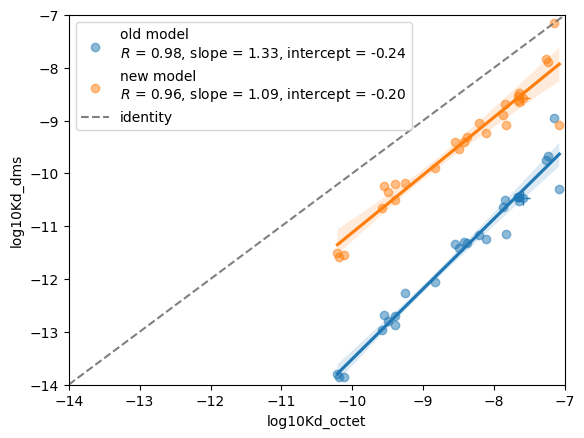

In [774]:
gl_row = octet_df.query("ID == 'GL'")
linreg_old = scipy.stats.linregress(octet_df.log10Kd_octet, octet_df.log10Kd_dms_old)
sns.regplot(data=octet_df,
            x="log10Kd_octet",
            y="log10Kd_dms_old",
            scatter_kws=dict(alpha=0.5),
            label=f"old model\n$R$ = {linreg_old.rvalue:.2f}, slope = {linreg_old.slope:.2f}, intercept = {linreg_old.intercept:.2f}",
            )
plt.plot(gl_row.log10Kd_octet, gl_row.log10Kd_dms_old, marker="+", markersize=10, c="C0")
linreg = scipy.stats.linregress(octet_df.log10Kd_octet, octet_df.log10Kd_dms)
sns.regplot(data=octet_df,
            x="log10Kd_octet",
            y="log10Kd_dms",
            scatter_kws=dict(alpha=0.5),
            label=f"new model\n$R$ = {linreg.rvalue:.2f}, slope = {linreg.slope:.2f}, intercept = {linreg.intercept:.2f}",
            )
plt.plot(gl_row.log10Kd_octet, gl_row.log10Kd_dms, marker="+", markersize=10, c="C1")
plt.plot([-14, -7], [-14, -7], color="gray", ls="--", label="identity")
plt.legend()
plt.xlim(-14, -7)
plt.ylim(-14, -7)
plt.show()